RUN EACH CELL FROM TOP TO BOTTOM

I MENTIONED WHICH CELL YOU DO NOT NEED TO RUN.

UPLOAD CSV FILE AND MODEL WHERE MENTIONED.

# In the ChemNODE paper:
They use odeint (the ODE solver) during training.

That means:

For each training step, the model predicts dy/dt.

Then odeint integrates it over time to get the full trajectory.

Then the model compares the predicted trajectory to the ground truth.

This process is part of the training loop.

This requires computing gradients through the ODE solver, using adjoint sensitivity or forward-mode differentiation.

# In my approach:
I train my neural network to directly match dy/dt, using:

loss = MSE(dy_pred, dy_true)
I only use odeint after training, to simulate and evaluate on test data.

This is called source term supervision.

It is computationally cheaper and much faster and giving me good resuls.

In [14]:
pip install torch pandas matplotlib torchdiffeq


In [15]:
import pandas as pd

# Load the dataset
df = pd.read_csv("/content/training_data.csv")

# Preview the data
print(df.head())
print(df.columns)


       time            y1            y2            y3        y4            y5  \
0  0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.195310  0.000000e+00   
1  0.000004  7.533600e-09  5.718574e-09  8.341660e-09  0.195309  1.112636e-08   
2  0.000008  1.751623e-08  5.693708e-09  1.081556e-08  0.195309  1.754109e-08   
3  0.000012  2.792153e-08  6.004496e-09  1.225763e-08  0.195309  2.103438e-08   
4  0.000016  3.922189e-08  6.365011e-09  1.368726e-08  0.195309  2.426660e-08   

             y6            y7            y8   y9  ...  y45  y46  y47  \
0  0.000000e+00  0.000000e+00  0.000000e+00  0.0  ...  0.0  0.0  0.0   
1  1.916966e-08  8.298149e-08  1.989069e-10  0.0  ...  0.0  0.0  0.0   
2  6.685755e-08  1.654532e-07  6.837422e-10  0.0  ...  0.0  0.0  0.0   
3  1.267284e-07  2.469054e-07  1.280462e-09  0.0  ...  0.0  0.0  0.0   
4  2.005724e-07  3.273257e-07  1.926908e-09  0.0  ...  0.0  0.0  0.0   

        y48  y49  y50  y51  y52  y53  temperature  
0  0.783345  0.0  0.0  0.0  

In [16]:
df.isnull().sum()

,0
time,0
y1,0
y2,0
y3,0
y4,0
y5,0
y6,0
y7,0
y8,0
y9,0


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 55 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   time         501 non-null    float64
 1   y1           501 non-null    float64
 2   y2           501 non-null    float64
 3   y3           501 non-null    float64
 4   y4           501 non-null    float64
 5   y5           501 non-null    float64
 6   y6           501 non-null    float64
 7   y7           501 non-null    float64
 8   y8           501 non-null    float64
 9   y9           501 non-null    float64
 10  y10          501 non-null    float64
 11  y11          501 non-null    float64
 12  y12          501 non-null    float64
 13  y13          501 non-null    float64
 14  y14          501 non-null    float64
 15  y15          501 non-null    float64
 16  y16          501 non-null    float64
 17  y17          501 non-null    float64
 18  y18          501 non-null    float64
 19  y19     

In [18]:
print(df.columns.tolist())


['time', 'y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8', 'y9', 'y10', 'y11', 'y12', 'y13', 'y14', 'y15', 'y16', 'y17', 'y18', 'y19', 'y20', 'y21', 'y22', 'y23', 'y24', 'y25', 'y26', 'y27', 'y28', 'y29', 'y30', 'y31', 'y32', 'y33', 'y34', 'y35', 'y36', 'y37', 'y38', 'y39', 'y40', 'y41', 'y42', 'y43', 'y44', 'y45', 'y46', 'y47', 'y48', 'y49', 'y50', 'y51', 'y52', 'y53', 'temperature']


In [ ]:
species_map = {
    'y1':  'CH4',
    'y2':  'O2',
    'y3':  'H2O',
    'y4':  'H2',
    'y5':  'CO',
    'y6':  'CO2',
    'y7':  'H',
    'y8':  'O',
    'y9':  'OH',
    'y10': 'HO2',
    'y11': 'H2O2',
    'y12': 'N2',
    'y13': 'AR',
    'y14': 'HE',
    'y15': 'C',
    'y16': 'CH',
    'y17': 'CH2',
    'y18': 'CH2(S)',
    'y19': 'CH3',
    'y20': 'CH4',     
    'y21': 'HCO',
    'y22': 'CH2O',
    'y23': 'CH2OH',
    'y24': 'CH3O',
    'y25': 'CH3OH',
    'y26': 'C2H2',
    'y27': 'C2H3',
    'y28': 'C2H4',
    'y29': 'C2H5',
    'y30': 'C2H6',
    'y31': 'HCCO',
    'y32': 'CH2CO',
    'y33': 'HCCOH',
    'y34': 'N',
    'y35': 'NH',
    'y36': 'NH2',
    'y37': 'NH3',
    'y38': 'NO',
    'y39': 'N2O',
    'y40': 'HNO',
    'y41': 'CN',
    'y42': 'HCN',
    'y43': 'H2CN',
    'y44': 'HCNN',
    'y45': 'HCNO',
    'y46': 'HOCN',
    'y47': 'HNCO',
    'y48': 'NCO',
    'y49': 'NNH',
    'y50': 'NO2',
    'y51': 'C3H7',
    'y52': 'C3H8',
    'y53': 'CH2CHO',
}


Direct training Y function but that doesn't give Good results.

Do Not run this Cell.

Do Not run this Cell.

In [ ]:
import torch
import torch.nn as nn
from torchdiffeq import odeint
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

# ===== Load Dataset =====
df = pd.read_csv("/content/training_data.csv")
selected_columns = ["temperature", "y1", "y2", "y3", "y5", "y6"]
data = df[selected_columns].values
times = df["time"].values

# ===== Normalize =====
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

data_tensor = torch.tensor(data_scaled, dtype=torch.float32)
t_tensor = torch.tensor(times, dtype=torch.float32)

# ===== Train-Validation Split =====
split_idx = int(0.8 * len(data_tensor))
data_tensor_train = data_tensor[:split_idx]
t_tensor_train = t_tensor[:split_idx]
data_tensor_val = data_tensor[split_idx:]
t_tensor_val = t_tensor[split_idx:]

# ===== Neural ODE Model (dy/dt = f(y)) =====
class ODEFunc(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, dim)
        )

    def forward(self, t, y):
        return self.net(y)

# ===== Model Setup =====
input_dim = data_tensor.shape[1]
func = ODEFunc(input_dim)
optimizer = torch.optim.Adam(func.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Initial condition
y0_train = data_tensor_train[0]
y_true_train = data_tensor_train

y0_val = data_tensor_val[0]
y_true_val = data_tensor_val

# ===== Training Loop =====
for epoch in range(1000):
    optimizer.zero_grad()

    # Predict trajectory using ODE solver
    y_pred = odeint(func, y0_train, t_tensor_train, method='dopri5')
    loss = loss_fn(y_pred, y_true_train)
    loss.backward()
    optimizer.step()

    # Validation
    with torch.no_grad():
        y_val_pred = odeint(func, y0_val, t_tensor_val, method='dopri5')
        val_loss = loss_fn(y_val_pred, y_true_val)

    if epoch % 50 == 0:
        print(f"Epoch {epoch} | Train Loss: {loss.item():.6f} | Val Loss: {val_loss.item():.6f}")

# Save the model
torch.save(func.state_dict(), "neural_ode_trained_on_y.pt")
print("✅ Model saved as neural_ode_trained_on_y.pt")


Do Not run this Cell.

In [ ]:
# Same model definition as training
class ODEFunc(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, dim)
        )

    def forward(self, t, y):
        return self.net(y)

# Load model
input_dim = len(selected_columns)  # same 6 variables
model = ODEFunc(input_dim)
model.load_state_dict(torch.load("neural_ode_trained_on_y.pt"))
model.eval()


ODEFunc(
  (net): Sequential(
    (0): Linear(in_features=6, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=6, bias=True)
  )
)

Do Not run this Cell.

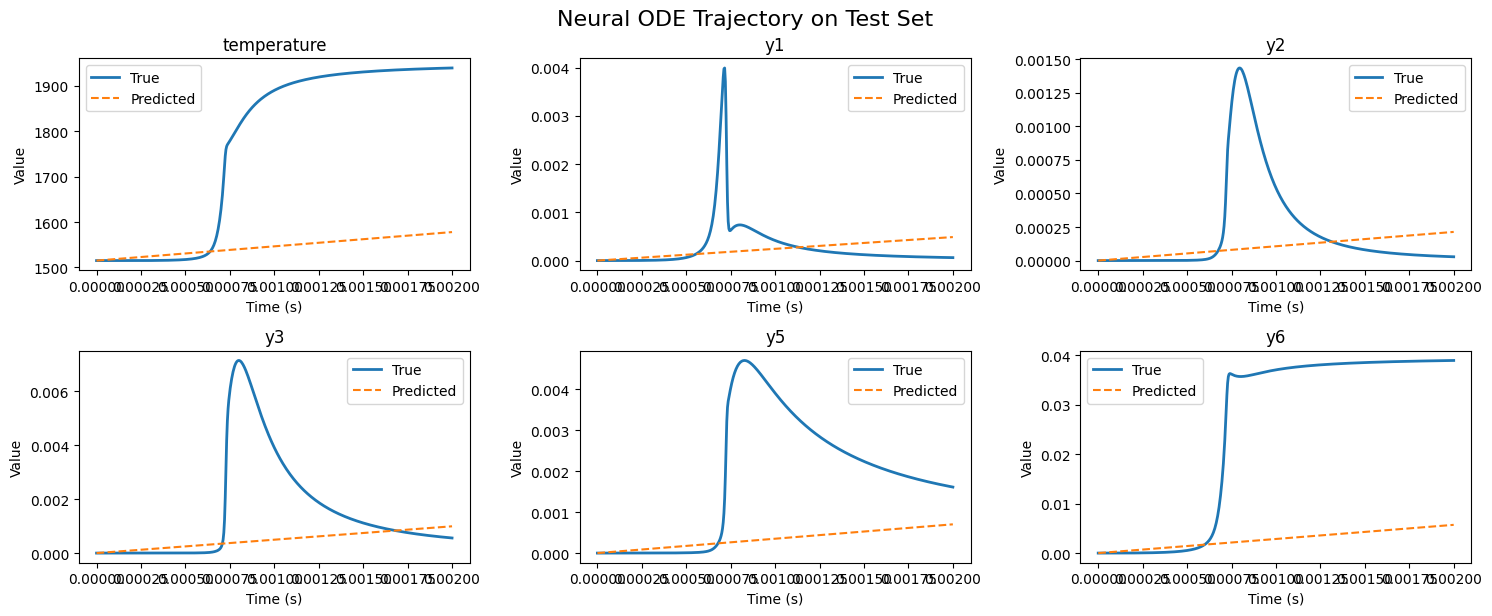

In [ ]:
import matplotlib.pyplot as plt

# Load and normalize test data
df_test = pd.read_csv("/content/testing_data.csv")
data_test = df_test[selected_columns].values
times_test = df_test["time"].values

data_test_scaled = scaler.transform(data_test)
data_test_tensor = torch.tensor(data_test_scaled, dtype=torch.float32)
t_test_tensor = torch.tensor(times_test, dtype=torch.float32)

# Predict using the first test state
with torch.no_grad():
    y0_test = data_test_tensor[0]
    y_pred = odeint(model, y0_test, t_test_tensor, method="dopri5")

# Denormalize predictions
y_pred_denorm = scaler.inverse_transform(y_pred.numpy())
y_true_denorm = scaler.inverse_transform(data_test_tensor.numpy())

# Plot
plt.figure(figsize=(15, 6))
for i, var in enumerate(selected_columns):
    plt.subplot(2, 3, i + 1)
    plt.plot(times_test, y_true_denorm[:, i], label="True", linewidth=2)
    plt.plot(times_test, y_pred_denorm[:, i], "--", label="Predicted")
    plt.title(var)
    plt.xlabel("Time (s)")
    plt.ylabel("Value")
    plt.legend()

plt.tight_layout()
plt.suptitle("Neural ODE Trajectory on Test Set", fontsize=16, y=1.02)
plt.show()


# Training Derivative

# **Dataset & Preprocessing**
We use time-series data of temperature and chemical species involved in methane combustion, generated from GRI-Mech 3.0 simulations. The data is normalized using MinMaxScaler to ensure numerical stability during training. We apply a Savitzky-Golay filter to smooth the data and compute dy/dt (i.e., source terms) for training.

# **Model Design**
Our model, SourceTermModel, is a deep feedforward neural network trained to learn the source term function
𝑓(𝑦)=𝑑𝑦/𝑑𝑡

of the system. This function is used inside the Neural ODE solver (odeint) to simulate the temporal evolution of species and temperature.

The architecture consists of:

Layer normalization on the input

7 linear layers with hidden dimensions:

128 → 128 → 128 → 128 → 64 → output dimension

SiLU activation after each linear layer (except the output)

Dropout (0.1) after the first hidden layer for regularization

This design allows the network to learn complex nonlinear relationships between variables in high-dimensional chemical space.


Layer normalization and dropout for regularization

Multiple hidden layers with SiLU activation

Output dimension matches the number of species (e.g., 53 in GRI-Mech 3.0)

# **Training Strategy**
We use mini-trajectory segmentation to create batches of sliding window sequences (e.g., size 10). The model is trained using MSE loss between predicted and true source terms. We use:

Adam optimizer with a learning rate of 1e-3

Batch size of 8

9000 training epochs

Periodic model checkpointing for performance comparison

# **Trajectory Simulation**
After training, we integrate the learned dynamics using odeint() from the torchdiffeq library. We simulate the entire test trajectory starting from the initial state and compare the predicted and true trajectories.

# **Evaluation Metrics**
We compute:

MAE, RMSE, and R² for each species

AMAE (Average MAE normalized by mean absolute values) to align with ChemNODE's evaluation strategy

-----------------------------------------------------

This is cell is for training dy/dt , So u do not have to run this,
since i already saved the model

In [ ]:
import torch
import torch.nn as nn
from torchdiffeq import odeint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter

# ===== Load Dataset =====
# df = pd.read_csv("/content/training_data.csv")
# selected_columns = ["temperature", "y1", "y2", "y3", "y5", "y6"]
# data = df[selected_columns].values
# times = df["time"].values
df = pd.read_csv("/content/training_data.csv")
selected_columns = df.columns.drop("time")  #selects all columns
data = df[selected_columns].values
times = df["time"].values

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
data_tensor = torch.tensor(data_scaled, dtype=torch.float32)
t_tensor = torch.tensor(times, dtype=torch.float32)

#Train/Validation Split
split_idx = int(0.8 * len(data_tensor))
data_tensor_train = data_tensor[:split_idx]
dy_dt_tensor_train = None
data_tensor_val = data_tensor[split_idx:]
dy_dt_tensor_val = None

#  Apply Savitzky-Golay filter and compute dy/dt
data_smooth = savgol_filter(data_scaled, window_length=7, polyorder=3, axis=0)
dt = np.diff(times).mean()
dy_dt = np.gradient(data_smooth, dt, axis=0)
dy_dt_tensor = torch.tensor(dy_dt, dtype=torch.float32)

dy_dt_tensor_train = dy_dt_tensor[:split_idx]
dy_dt_tensor_val = dy_dt_tensor[split_idx:]

# Create Mini Trajectories for Augmentation
def create_mini_trajectories(data_tensor, dy_tensor, window_size=10):
    x_segs = []
    dy_segs = []
    for i in range(len(data_tensor) - window_size):
        x_segs.append(data_tensor[i:i + window_size])
        dy_segs.append(dy_tensor[i:i + window_size])
    return torch.stack(x_segs), torch.stack(dy_segs)

x_segs_train, dy_segs_train = create_mini_trajectories(data_tensor_train, dy_dt_tensor_train, window_size=10)
x_segs_val, dy_segs_val = create_mini_trajectories(data_tensor_val, dy_dt_tensor_val, window_size=10)

#  Neural Network to Predict dy/dt
class SourceTermModel(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, 128),
            nn.SiLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 128),
            nn.SiLU(),
            nn.Linear(128, 128),
            nn.SiLU(),
            nn.Linear(128, 128),
            nn.SiLU(),
            # nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.SiLU(),
            nn.Linear(64, dim)
        )

    def forward(self, t, y):
        return self.net(y)

#  Train Model
input_dim = data_tensor.shape[1]
model = SourceTermModel(input_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

num_epochs = 3000
batch_size = 8
n_train = len(x_segs_train)

for epoch in range(num_epochs):
    model.train()
    permutation = torch.randperm(n_train)
    total_loss = 0.0

    for i in range(0, n_train, batch_size):
        indices = permutation[i:i + batch_size]
        y_batch = x_segs_train[indices].reshape(-1, input_dim)
        dy_true = dy_segs_train[indices].reshape(-1, input_dim)

        optimizer.zero_grad()
        dy_pred = model(torch.tensor(0.0), y_batch)
        loss = loss_fn(dy_pred, dy_true)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / (n_train // batch_size)

    # Validation
    model.eval()
    with torch.no_grad():
        y_val = x_segs_val.reshape(-1, input_dim)
        dy_val_true = dy_segs_val.reshape(-1, input_dim)
        dy_val_pred = model(torch.tensor(0.0), y_val)
        val_loss = loss_fn(dy_val_pred, dy_val_true).item()
        r2 = r2_score(dy_val_true.numpy(), dy_val_pred.numpy())

    if epoch % 20 == 0:
        print(f"Epoch {epoch:>4} | Train MSE: {avg_loss:.6f} | Val MSE: {val_loss:.6f} | R²: {r2:.6f}")

    if epoch % 300 == 0 and epoch > 0:
        torch.save(model.state_dict(), f"model_epoch_v{epoch}.pt")
        print(f"✅ Model saved at epoch {epoch} -> model_epoch_v_{epoch}.pt")

# Save the final model
torch.save(model.state_dict(), "final_model_v.pt")
print("\n✅ Source-term model trained and saved as final_model.pt")


Trajectory

In [22]:
import torch
import torch.nn as nn
from torchdiffeq import odeint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter

UPLOAD training_data.csv

In [ ]:

df_train = pd.read_csv("/content/training_data.csv")
train_data = df_train.drop(columns=["time"]).values

# Fit scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_data)



MinMaxScaler()

FOR MAJOR SPECIES

    'y1':  'CH₄',
    'y2':  'O₂',
    'y3':  'H₂O',
    'y4':  'H₂',
    'y5':  'CO',
    'y6':  'CO₂'

UPLOAD testing_data.csv AND model_epoch_v600.pt

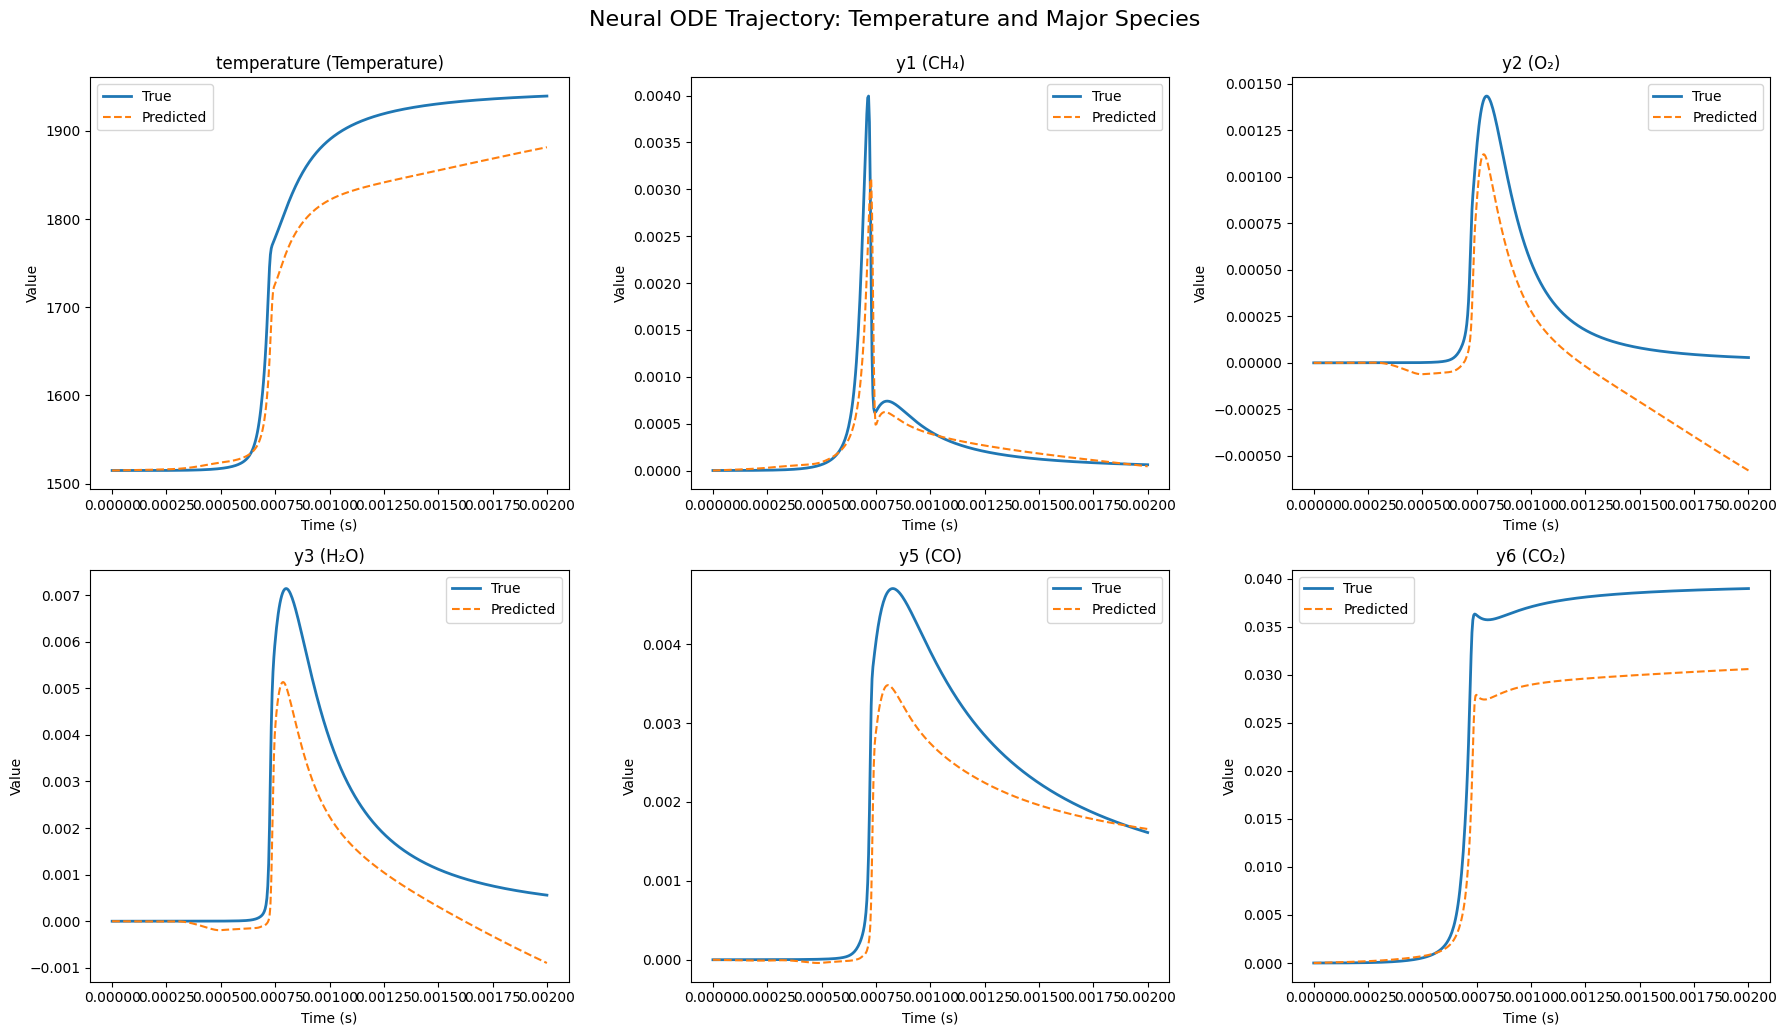

In [24]:
import matplotlib.pyplot as plt
import math

# ===== Load test data =====
df_test = pd.read_csv("/content/testing_data.csv")
data_test = df_test.drop(columns=["time"]).values
times_test = df_test["time"].values

# ===== Normalize using training scaler =====
data_test_scaled = scaler.transform(data_test)
data_test_tensor = torch.tensor(data_test_scaled, dtype=torch.float32)
t_test_tensor = torch.tensor(times_test, dtype=torch.float32)


input_dim = data_test_tensor.shape[1]

class SourceTermModel(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, 128),
            nn.SiLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 128),
            nn.SiLU(),
            nn.Linear(128, 128),
            nn.SiLU(),
            nn.Linear(128, 128),
            nn.SiLU(),
            nn.Linear(128, 64),
            nn.SiLU(),
            nn.Linear(64, dim)
        )

    def forward(self, t, y):
        return self.net(y)

# ===== Load trained model =====
model = SourceTermModel(input_dim)
model.load_state_dict(torch.load("model_epoch_v600.pt"))
model.eval()

# ===== Simulate trajectory using Neural ODE =====
with torch.no_grad():
    y0 = data_test_tensor[0]
    y_pred = odeint(model, y0, t_test_tensor, method="dopri5")

# ===== Denormalize =====
y_pred_denorm = scaler.inverse_transform(y_pred.numpy())
y_true_denorm = scaler.inverse_transform(data_test_tensor.numpy())
columns = df_test.columns.drop("time")

target_vars = ["temperature", "y1", "y2", "y3", "y5", "y6"]
species_map = {
    'y1':  'CH₄',
    'y2':  'O₂',
    'y3':  'H₂O',
    'y4':  'H₂',
    'y5':  'CO',
    'y6':  'CO₂'
}


plt.figure(figsize=(18, 10))
for i, var in enumerate(target_vars):
    col_idx = columns.get_loc(var)
    label = f"{var} ({'Temperature' if var == 'temperature' else species_map.get(var, var)})"

    plt.subplot(2, 3, i + 1)
    plt.plot(times_test, y_true_denorm[:, col_idx], label='True', linewidth=2)
    plt.plot(times_test, y_pred_denorm[:, col_idx], '--', label='Predicted')
    plt.title(label)
    plt.xlabel("Time (s)")
    plt.ylabel("Value")
    plt.legend()

plt.tight_layout()
plt.suptitle("Neural ODE Trajectory: Temperature and Major Species", y=1.03, fontsize=16)
plt.show()


In [25]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_species_metrics(y_true, y_pred, column_names):
    results = []
    amae_list = []

    for i, name in enumerate(column_names):
        true_col = y_true[:, i]
        pred_col = y_pred[:, i]

        mae = mean_absolute_error(true_col, pred_col)
        mse = mean_squared_error(true_col, pred_col)
        rmse = np.sqrt(mse)
        r2 = r2_score(true_col, pred_col)

        mean_ref = np.mean(np.abs(true_col)) + 1e-8
        amae = mae / mean_ref
        amae_list.append(amae)

        results.append({
            "Species": name,
            "MAE": mae,
            "RMSE": rmse,
            "R²": r2,
            "AMAE": amae
        })

    df_results = pd.DataFrame(results)
    avg_amae = np.mean(amae_list)

    print("📊 Average AMAE (ChemNODE style):", f"{avg_amae:.6f}")
    return df_results

selected_columns = ["temperature", "y1", "y2", "y3", "y5", "y6"]
metrics_df = evaluate_species_metrics(y_true_denorm, y_pred_denorm, selected_columns)
print(metrics_df.to_string(index=False))


📊 Average AMAE (ChemNODE style): 0.404683
    Species      MAE     RMSE       R²     AMAE
temperature 0.000092 0.000255 0.770449 0.325583
         y1 0.000229 0.000290 0.362829 1.059429
         y2 0.000850 0.001108 0.676605 0.560597
         y3 0.006393 0.007816 0.835065 0.037853
         y5 0.000391 0.000618 0.840559 0.214725
         y6 0.005705 0.006942 0.844708 0.229910


AMAE stands for Average Mean Absolute Error, but in the ChemNODE context, it’s a normalized error metric. It tells us how large the prediction errors are relative to the true average values of the species

FOR ALL SPECIES

UPLOAD testing_data.csv AND model_epoch_v600.pt

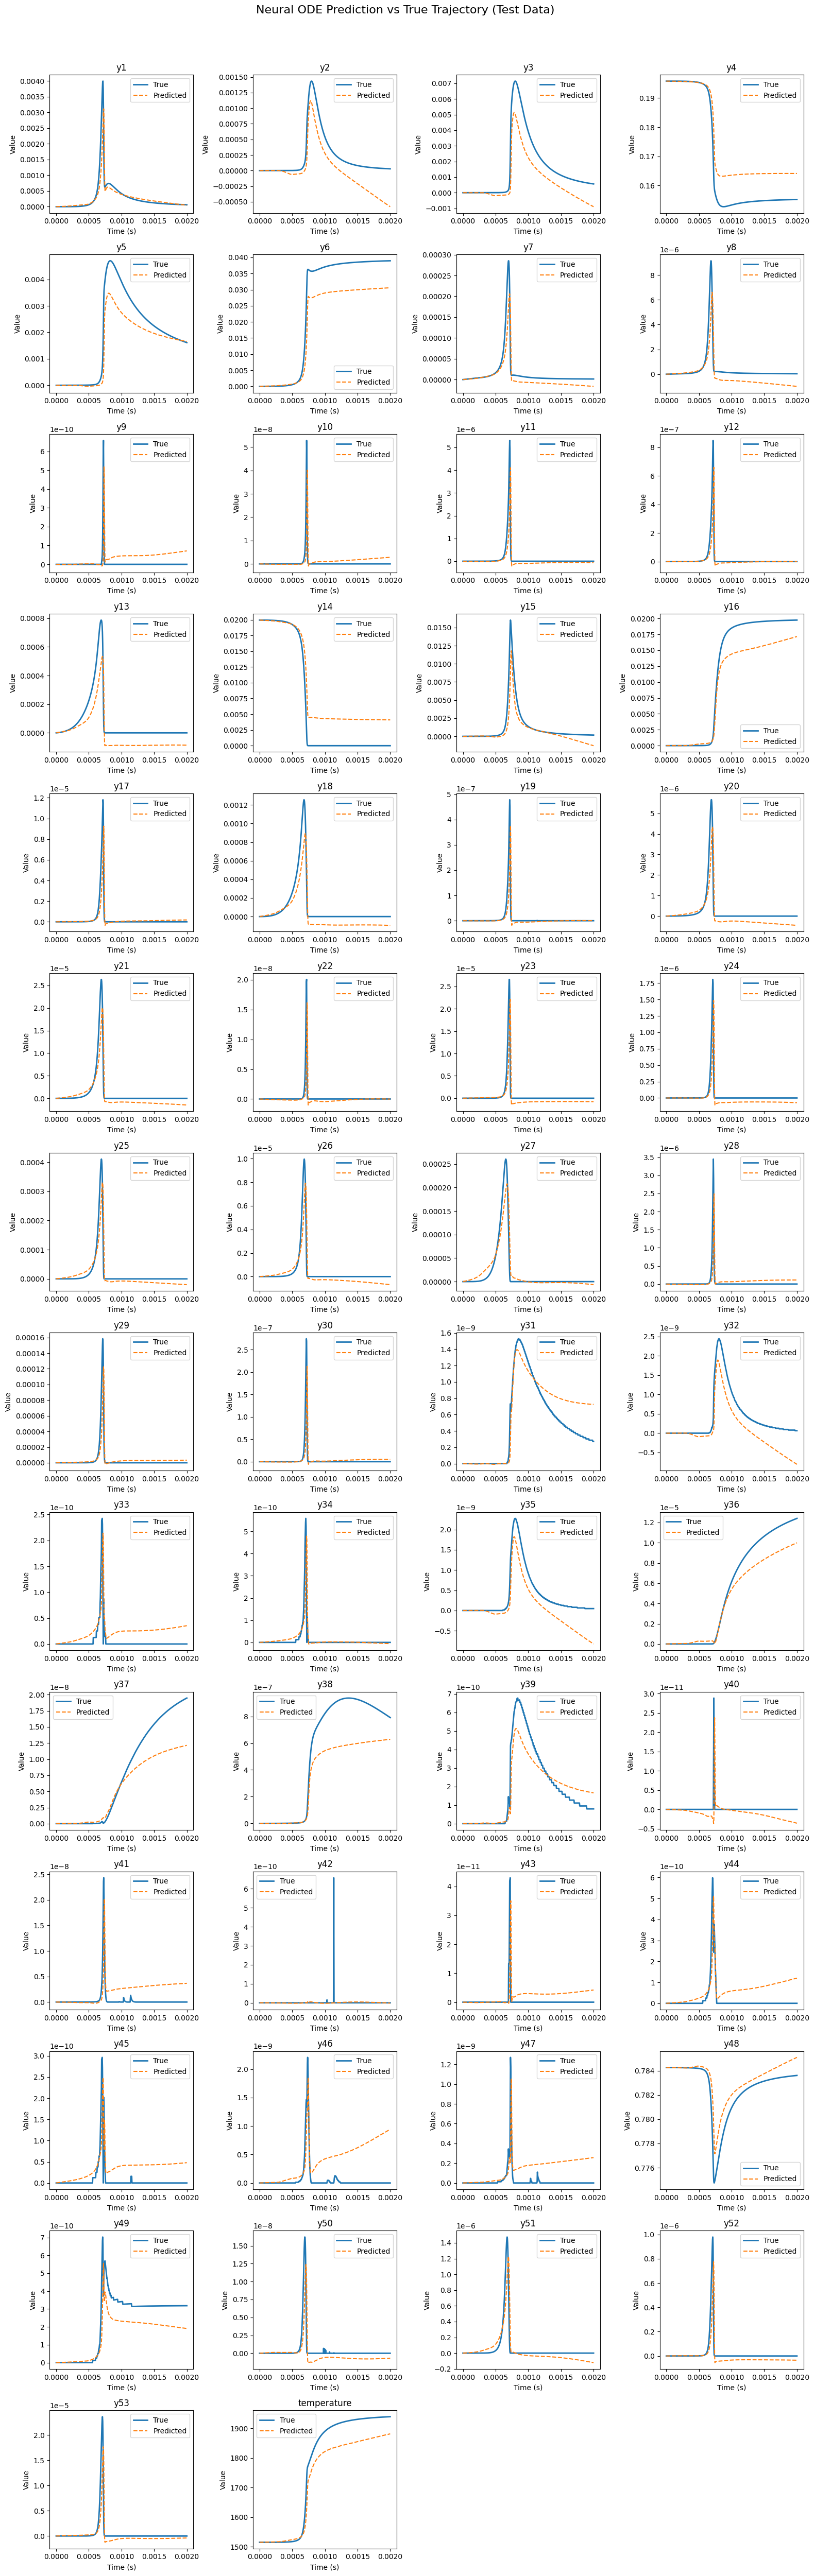

In [ ]:
import matplotlib.pyplot as plt
import math

#  Load test data 
df_test = pd.read_csv("/content/testing_data.csv")
data_test = df_test.drop(columns=["time"]).values
times_test = df_test["time"].values

#  Normalize using training scaler
data_test_scaled = scaler.transform(data_test)
data_test_tensor = torch.tensor(data_test_scaled, dtype=torch.float32)
t_test_tensor = torch.tensor(times_test, dtype=torch.float32)

#  Load trained model 
input_dim = data_test_tensor.shape[1]

class SourceTermModel(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, 128),
            nn.SiLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 128),
            nn.SiLU(),
            nn.Linear(128, 128),
            nn.SiLU(),
            nn.Linear(128, 128),
            nn.SiLU(),
            nn.Linear(128, 64),
            nn.SiLU(),
            nn.Linear(64, dim)
        )
    def forward(self, t, y):
        return self.net(y)

model = SourceTermModel(input_dim)
model.load_state_dict(torch.load("model_epoch_v600.pt"))
model.eval()
# 600,2100

# Simulate trajectory using Neural ODE 
with torch.no_grad():
    y0 = data_test_tensor[0]
    y_pred = odeint(model, y0, t_test_tensor, method="dopri5")

#  Denormalize 
y_pred_denorm = scaler.inverse_transform(y_pred.numpy())
y_true_denorm = scaler.inverse_transform(data_test_tensor.numpy())
columns = df_test.columns.drop("time")


n_vars = len(columns)
ncols = 4
nrows = math.ceil(n_vars / ncols)

plt.figure(figsize=(4 * ncols, 3.5 * nrows))
for i, var in enumerate(columns):
    plt.subplot(nrows, ncols, i + 1)
    plt.plot(times_test, y_true_denorm[:, i], label='True', linewidth=2)
    plt.plot(times_test, y_pred_denorm[:, i], '--', label='Predicted')
    plt.title(var)
    plt.xlabel("Time (s)")
    plt.ylabel("Value")
    plt.legend()

plt.tight_layout()
plt.suptitle("Neural ODE Prediction vs True Trajectory (Test Data)", y=1.02, fontsize=16)
plt.show()

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np


def evaluate_metrics(y_true, y_pred, column_names):
    results = []
    for i, name in enumerate(column_names):
        y_true_i = y_true[:, i]
        y_pred_i = y_pred[:, i]
        mae = mean_absolute_error(y_true_i, y_pred_i)
        mse = mean_squared_error(y_true_i, y_pred_i)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true_i, y_pred_i)
        results.append({
            "Variable": name,
            "MAE": mae,
            "RMSE": rmse,
            "R²": r2
        })

    df_results = pd.DataFrame(results)
    avg_metrics = df_results[["MAE", "RMSE", "R²"]].mean()
    print("📊 Per-variable Metrics:")
    print(df_results.to_string(index=False))

    print("\n📈 Average Metrics Across All Variables:")
    print(f"Avg MAE : {avg_metrics['MAE']:.6f}")
    print(f"Avg RMSE: {avg_metrics['RMSE']:.6f}")
    print(f"Avg R²  : {avg_metrics['R²']:.6f}")

    return df_results

# ===== Run Evaluation =====
metrics_df = evaluate_metrics(y_true_denorm, y_pred_denorm, columns)


📊 Per-variable Metrics:
   Variable          MAE         RMSE        R²
         y1 9.189460e-05 2.550529e-04  0.770449
         y2 2.293845e-04 2.900605e-04  0.362829
         y3 8.497133e-04 1.108160e-03  0.676605
         y4 6.392727e-03 7.815688e-03  0.835065
         y5 3.907609e-04 6.181414e-04  0.840559
         y6 5.705134e-03 6.942440e-03  0.844708
         y7 1.366673e-05 2.331885e-05  0.719648
         y8 6.333221e-07 8.963297e-07  0.530496
         y9 3.760993e-11 6.313461e-11 -0.872992
        y10 1.589020e-09 3.913214e-09  0.100763
        y11 1.165138e-07 3.682700e-07  0.548318
        y12 1.362112e-08 5.799367e-08  0.572749
        y13 8.603095e-05 1.052610e-04  0.602950
        y14 2.932723e-03 3.534143e-03  0.848483
        y15 6.348933e-04 1.263937e-03  0.775699
        y16 2.278885e-03 2.856866e-03  0.901335
        y17 2.345204e-07 8.136299e-07  0.645296
        y18 9.057729e-05 1.208284e-04  0.755569
        y19 7.812274e-09 3.297173e-08  0.538974
        y20 3.10

Do Not run this cell , this is just for checking which model is best

In [ ]:
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import torch


model_dir = "."
model_files = sorted([f for f in os.listdir(model_dir) if f.startswith("model_epoch_v") and f.endswith(".pt")])

results = []

for model_file in model_files:
    # Load model
    model = SourceTermModel(input_dim)
    model.load_state_dict(torch.load(os.path.join(model_dir, model_file)))
    model.eval()

    # Predict on test set
    with torch.no_grad():
        y0 = data_test_tensor[0]
        y_pred = odeint(model, y0, t_test_tensor, method="dopri5")
        y_pred_denorm = scaler.inverse_transform(y_pred.numpy())

    # Metrics
    mae = mean_absolute_error(y_true_denorm, y_pred_denorm)
    mse = mean_squared_error(y_true_denorm, y_pred_denorm)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true_denorm, y_pred_denorm)

    results.append({
        "Model": model_file,
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2
    })


df_results = pd.DataFrame(results)

print("\n🔝 Top 5 models by lowest MAE:")
print(df_results.sort_values("MAE").head(5).to_string(index=False))

print("\n🔝 Top 5 models by lowest RMSE:")
print(df_results.sort_values("RMSE").head(5).to_string(index=False))

print("\n🔝 Top 5 models by highest R²:")
print(df_results.sort_values("R²", ascending=False).head(5).to_string(index=False))



🔝 Top 5 models by lowest MAE:
               Model      MAE      RMSE        R²
model_epoch_v2100.pt 0.312622  4.776934 -0.771621
model_epoch_v1800.pt 0.704941  8.516359 -2.780520
model_epoch_v2400.pt 0.799000  8.694049 -6.808960
 model_epoch_v600.pt 0.859380  7.668966  0.398083
 model_epoch_v300.pt 1.040298 11.626051 -1.774768

🔝 Top 5 models by lowest RMSE:
               Model      MAE      RMSE        R²
model_epoch_v2100.pt 0.312622  4.776934 -0.771621
 model_epoch_v600.pt 0.859380  7.668966  0.398083
model_epoch_v1800.pt 0.704941  8.516359 -2.780520
model_epoch_v2400.pt 0.799000  8.694049 -6.808960
 model_epoch_v300.pt 1.040298 11.626051 -1.774768

🔝 Top 5 models by highest R²:
               Model      MAE      RMSE        R²
 model_epoch_v600.pt 0.859380  7.668966  0.398083
model_epoch_v1200.pt 4.628799 42.227500 -0.535661
model_epoch_v2100.pt 0.312622  4.776934 -0.771621
model_epoch_v6000.pt 1.481075 17.376232 -1.522660
model_epoch_v3300.pt 1.083793 11.845903 -1.555838


# Training Data

Trajectory Plot

UPLOAD training_data.csv AND model_epoch_v600.pt

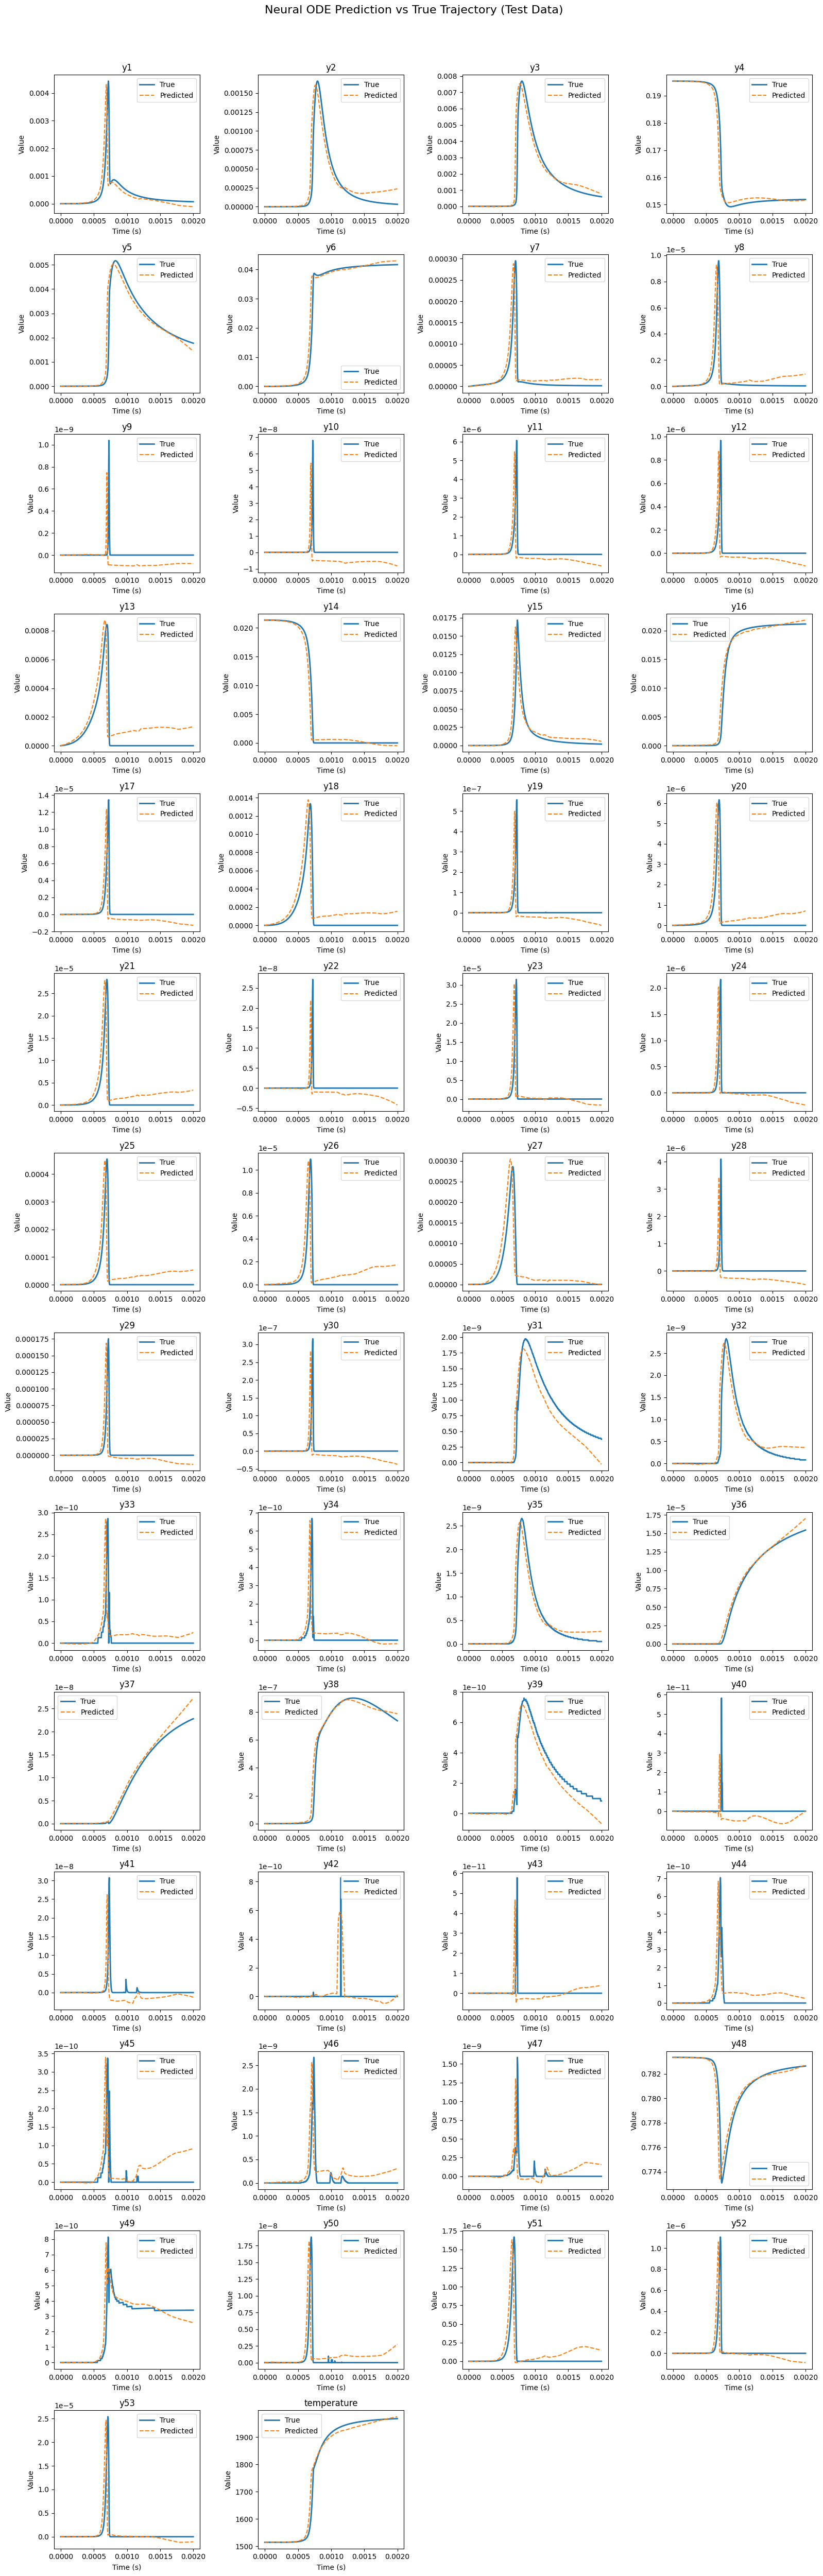

In [ ]:
import matplotlib.pyplot as plt
import math

#  Load test data 
df_test = pd.read_csv("/content/training_data.csv")
data_test = df_test.drop(columns=["time"]).values
times_test = df_test["time"].values

# Normalize using training scaler
data_test_scaled = scaler.transform(data_test)
data_test_tensor = torch.tensor(data_test_scaled, dtype=torch.float32)
t_test_tensor = torch.tensor(times_test, dtype=torch.float32)

#  Load trained model
input_dim = data_test_tensor.shape[1]

class SourceTermModel(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, 128),
            nn.SiLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 128),
            nn.SiLU(),
            nn.Linear(128, 128),
            nn.SiLU(),
            nn.Linear(128, 128),
            nn.SiLU(),
            nn.Linear(128, 64),
            nn.SiLU(),
            nn.Linear(64, dim)
        )
    def forward(self, t, y):
        return self.net(y)

model = SourceTermModel(input_dim)
model.load_state_dict(torch.load("model_epoch_v600.pt"))
model.eval()


# Simulate trajectory using Neural ODE 
with torch.no_grad():
    y0 = data_test_tensor[0]
    y_pred = odeint(model, y0, t_test_tensor, method="dopri5")

# Denormalize 
y_pred_denorm = scaler.inverse_transform(y_pred.numpy())
y_true_denorm = scaler.inverse_transform(data_test_tensor.numpy())
columns = df_test.columns.drop("time")

#  Plotting all variables 
n_vars = len(columns)
ncols = 4
nrows = math.ceil(n_vars / ncols)

plt.figure(figsize=(4 * ncols, 3.5 * nrows))
for i, var in enumerate(columns):
    plt.subplot(nrows, ncols, i + 1)
    plt.plot(times_test, y_true_denorm[:, i], label='True', linewidth=2)
    plt.plot(times_test, y_pred_denorm[:, i], '--', label='Predicted')
    plt.title(var)
    plt.xlabel("Time (s)")
    plt.ylabel("Value")
    plt.legend()

plt.tight_layout()
plt.suptitle("Neural ODE Prediction vs True Trajectory (Test Data)", y=1.02, fontsize=16)
plt.show()


Do not run this cell , this is just for checking which is best on training data set

In [ ]:
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import torch

#  Prepare 
model_dir = "."
model_files = sorted([f for f in os.listdir(model_dir) if f.startswith("model_epoch_v") and f.endswith(".pt")])

results = []

for model_file in model_files:
    # Load model
    model = SourceTermModel(input_dim)
    model.load_state_dict(torch.load(os.path.join(model_dir, model_file)))
    model.eval()

    # Predict on test set
    with torch.no_grad():
        y0 = data_test_tensor[0]
        y_pred = odeint(model, y0, t_test_tensor, method="dopri5")
        y_pred_denorm = scaler.inverse_transform(y_pred.numpy())

    # Metrics
    mae = mean_absolute_error(y_true_denorm, y_pred_denorm)
    mse = mean_squared_error(y_true_denorm, y_pred_denorm)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true_denorm, y_pred_denorm)

    results.append({
        "Model": model_file,
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2
    })


df_results = pd.DataFrame(results)


print("\n🔝 Top 5 models by lowest MAE:")
print(df_results.sort_values("MAE").head(5).to_string(index=False))

print("\n🔝 Top 5 models by lowest RMSE:")
print(df_results.sort_values("RMSE").head(5).to_string(index=False))

print("\n🔝 Top 5 models by highest R²:")
print(df_results.sort_values("R²", ascending=False).head(5).to_string(index=False))



🔝 Top 5 models by lowest MAE:
               Model      MAE      RMSE        R²
model_epoch_v2100.pt 0.194623  2.827904 -0.058465
model_epoch_v8400.pt 0.500177  6.597842 -6.305677
model_epoch_v1800.pt 0.532006  8.068788 -4.312263
model_epoch_v2400.pt 0.771787 10.747358 -1.016160
model_epoch_v4800.pt 0.910376 13.248464 -8.638292

🔝 Top 5 models by lowest RMSE:
               Model      MAE      RMSE        R²
model_epoch_v2100.pt 0.194623  2.827904 -0.058465
model_epoch_v8400.pt 0.500177  6.597842 -6.305677
model_epoch_v1800.pt 0.532006  8.068788 -4.312263
model_epoch_v2400.pt 0.771787 10.747358 -1.016160
 model_epoch_v600.pt 1.226118 11.092187 -0.203609

🔝 Top 5 models by highest R²:
               Model      MAE      RMSE        R²
model_epoch_v2100.pt 0.194623  2.827904 -0.058465
 model_epoch_v600.pt 1.226118 11.092187 -0.203609
model_epoch_v4500.pt 4.999963 45.687545 -0.429017
model_epoch_v5100.pt 4.982279 45.536732 -0.448203
model_epoch_v1200.pt 4.931789 45.079704 -0.508510
